In [1]:
import os
os.chdir("d:/python_projects/london-city-bikes")

import numpy as np
import torch
import matplotlib.pyplot as plt
import mlflow

In [29]:
#from src.dataset import get_dataloaders
from src.dataset_all_clusters import get_dataloaders
from src.model import LSTMModel, LinearWeightedMSELoss
from src.train import train_model, DEVICE
from src.metrics import evaluate_predictions
from src.predict import predict
from src.mlflow_logging import log_trained_model, log_true_and_predictions_values
from src.mlflow_logging import log_model_architecture, log_train_parameters
from src.mlflow_logging import log_train_parameters_with_embedding

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
PRED_LENGTH = 48
MODELS_BASENAME = "pytorch_model"
print(f"Using device: {DEVICE}")

Using device: cuda


In [16]:
#train_dataloaders, val_dataloaders, scalers, cluster_id_map = get_dataloaders(use_cluster_embedding_input=False)

In [30]:
train_dataloader, val_dataloader, scalers, cluster_id_map = get_dataloaders(use_cluster_embedding_input=True)

# Training

Custom errors implementation

In [25]:
# Hyperparameters
INPUT_SIZE = 12
FUTURE_FEATURE_SIZE = 10
HIDDEN_SIZE = 128
OUTPUT_SIZE = 2 * PRED_LENGTH
NUM_LAYERS = 1
NUM_EPOCHS = 50
DROPOUT = 0
LEARNING_RATE = 0.0001
USE_CLUSTER_EMBEDDING = True

# Train one model for all clusters

Epoch [1/50] - Train Loss: 0.0298, Train MAE: 0.1078, Val Loss: 0.0166, Val MAE: 0.0805
Epoch [2/50] - Train Loss: 0.0106, Train MAE: 0.0664, Val Loss: 0.0088, Val MAE: 0.0596
Epoch [3/50] - Train Loss: 0.0067, Train MAE: 0.0539, Val Loss: 0.0074, Val MAE: 0.0537
Epoch [4/50] - Train Loss: 0.0056, Train MAE: 0.0490, Val Loss: 0.0067, Val MAE: 0.0499
Epoch [5/50] - Train Loss: 0.0048, Train MAE: 0.0448, Val Loss: 0.0058, Val MAE: 0.0460
Epoch [6/50] - Train Loss: 0.0042, Train MAE: 0.0414, Val Loss: 0.0054, Val MAE: 0.0435
Epoch [7/50] - Train Loss: 0.0038, Train MAE: 0.0389, Val Loss: 0.0050, Val MAE: 0.0416
Epoch [8/50] - Train Loss: 0.0035, Train MAE: 0.0370, Val Loss: 0.0047, Val MAE: 0.0405
Epoch [9/50] - Train Loss: 0.0032, Train MAE: 0.0356, Val Loss: 0.0045, Val MAE: 0.0394
Epoch [10/50] - Train Loss: 0.0031, Train MAE: 0.0345, Val Loss: 0.0044, Val MAE: 0.0385
Epoch [11/50] - Train Loss: 0.0029, Train MAE: 0.0336, Val Loss: 0.0042, Val MAE: 0.0378
Epoch [12/50] - Train Loss: 0.

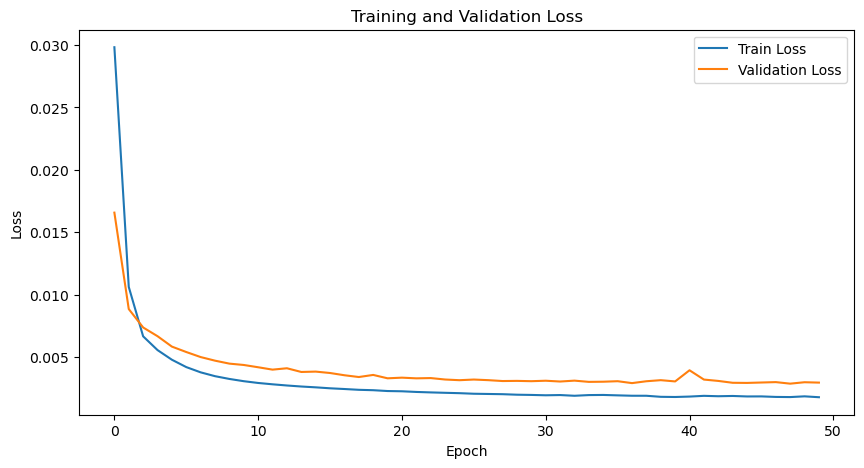

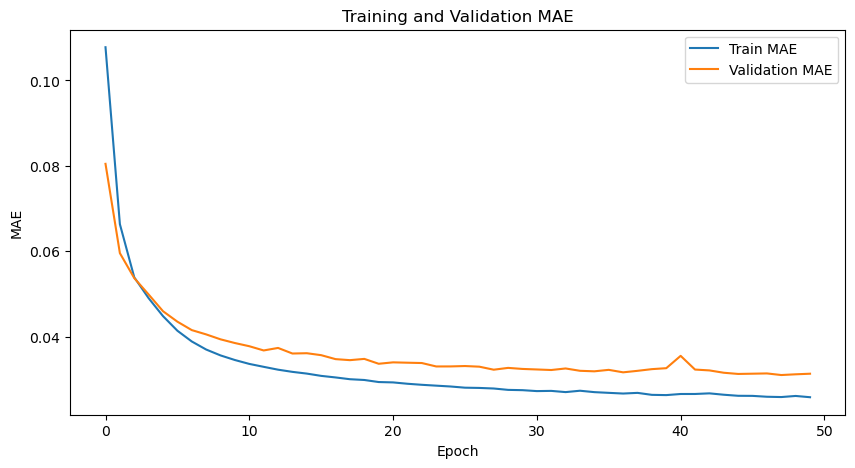

2025/04/16 20:33:29 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/16 20:33:35 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/16 20:33:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Metrics:
  MAE: 9.7633, RMSE: 15.0837, R2: 0.9174, sMAPE: 57.0106%


In [26]:
model = LSTMModel(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    future_feature_size=FUTURE_FEATURE_SIZE,
    output_size=OUTPUT_SIZE,
    pred_length=PRED_LENGTH,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    use_cluster_embedding=USE_CLUSTER_EMBEDDING,
    num_clusters=len(cluster_id_map),
    cluster_emb_size=8
).to(DEVICE)

criterion = LinearWeightedMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

mlflow.start_run()
log_model_architecture(model)
log_train_parameters_with_embedding(NUM_EPOCHS, optimizer, criterion, train_dataloader.batch_size, USE_CLUSTER_EMBEDDING)

model = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs=NUM_EPOCHS)
torch.save(model, f'./data/models/model_with_embeddings.pth')
log_trained_model(model, MODELS_BASENAME + "_with_embedding.pth")

all_preds = {}
all_true = {}

preds, true_vals, metadata = predict(model, val_dataloader)

metrics = evaluate_predictions(true_vals, preds, metadata)
print(f"Metrics:")
print(f"  MAE: {metrics['MAE']:.4f}, RMSE: {metrics['RMSE']:.4f}, R2: {metrics['R2']:.4f}, sMAPE: {metrics['sMAPE']:.4f}%")

np.save(f"./data/results/true_values.npy", true_vals)
np.save(f"./data/results/predictions.npy", preds)
log_true_and_predictions_values(f"./data/results/true_values.npy", f"./data/results/predictions.npy")

mlflow.end_run()

In [27]:
index = 0

selected_true = true_vals[index]
selected_predictions = preds[index]

# Extract true and predicted values for Starts and Ends
true_starts = selected_true[:, 0]  # Shape: (pred_length)
true_ends = selected_true[:, 1]    # Shape: (pred_length)
pred_starts = selected_predictions[:, 0]  # Shape: (pred_length)
pred_ends = selected_predictions[:, 1]    # Shape: (pred_length)

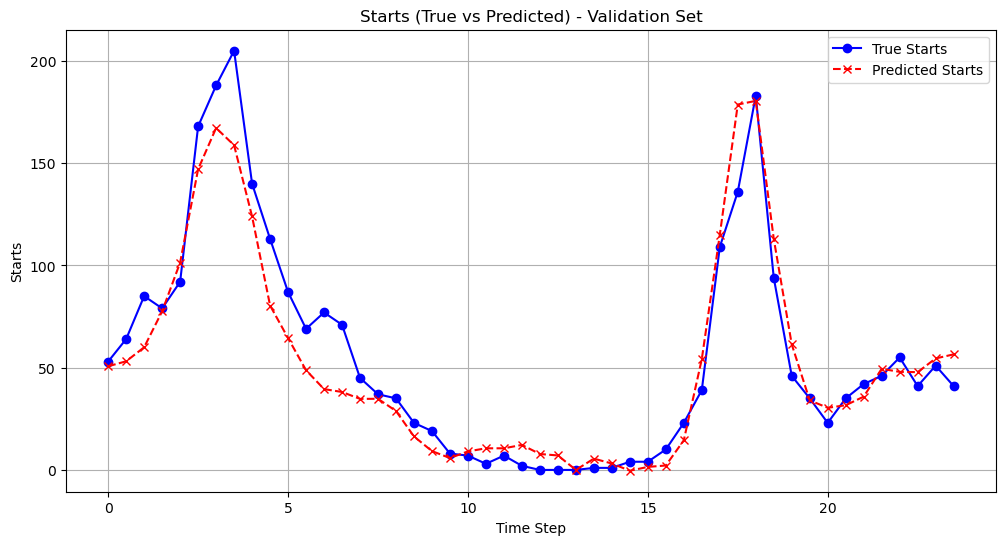

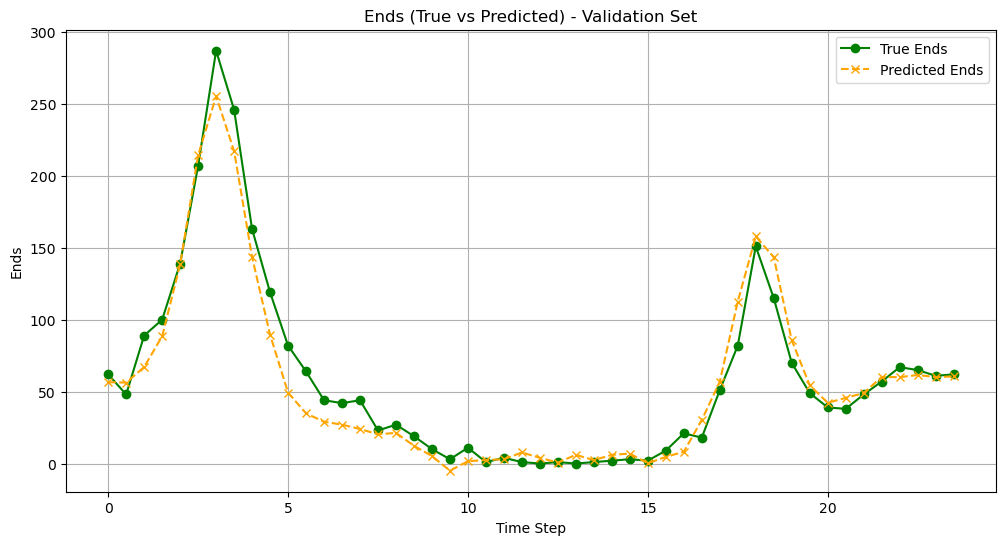

In [28]:
# Plot Starts for the first sample in the batch
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, PRED_LENGTH/2 - 0.5, PRED_LENGTH), true_starts, label="True Starts", color="blue", marker="o")
plt.plot(np.linspace(0, PRED_LENGTH/2 - 0.5, PRED_LENGTH), pred_starts, label="Predicted Starts", color="red", linestyle="--", marker="x")
plt.title(f"Starts (True vs Predicted) - Validation Set")
plt.xlabel("Time Step")
plt.ylabel("Starts")
plt.legend()
plt.grid(True)
plt.show()

# Plot Ends for the first sample in the batch
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, PRED_LENGTH/2 - 0.5, PRED_LENGTH), true_ends, label="True Ends", color="green", marker="o")
plt.plot(np.linspace(0, PRED_LENGTH/2 - 0.5, PRED_LENGTH), pred_ends, label="Predicted Ends", color="orange", linestyle="--", marker="x")
plt.title(f"Ends (True vs Predicted) - Validation Set")
plt.xlabel("Time Step")
plt.ylabel("Ends")
plt.legend()
plt.grid(True)
plt.show()